# Decomposoitions and Plots

In [1]:
import numpy as np
import h5py
import torch
import matplotlib.pyplot as plt


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Jan 19 20:46:48 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P0             52W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
# Import google drive mounting module
from google.colab import drive

# Import os/path lib to navigate the colab directory.
import os
import pathlib


# Mount Google Drive at the default location
drive.mount('/content/drive', force_remount=False)
# Define the path to your desired folder
path = '/content/drive/My Drive/OPM-MEG'
# Change to that directory
os.chdir(path)
# Verify the current working directory
print("Current Directory:", os.getcwd())

Mounted at /content/drive
Current Directory: /content/drive/My Drive/OPM-MEG


In [3]:
!git clone https://github.com/hug0-w/Tensor-Decompositions-OPM-MEG/
!pip install tensorly

fatal: destination path 'Tensor-Decompositions-OPM-MEG' already exists and is not an empty directory.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 68.4 MB/s eta 0:00:00


In [4]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 67.5 MB/s eta 0:00:00


In [5]:
!pip install nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 103.8 MB/s eta 0:00:00


# Outcome

In [6]:
mat_file = 'Outcome_TFR_ROI_Averaged.mat'

with h5py.File(mat_file, 'r') as f:
    tensor = np.array(f['tensor'])  # [Trials x ROIs x Freq x Time]
    time_vec = np.array(f['time_vec']).flatten()
    freq_vec = np.array(f['freq_vec']).flatten()

    # ROI labels (stored as HDF5 references)
    roi_labels = [''.join(chr(c) for c in f[ref][:].flatten()) for ref in f['roi_labels'][:].flatten()]

print(f"Tensor shape: {tensor.shape}")
print(f"Time: {time_vec[0]:.3f} to {time_vec[-1]:.3f} s ({len(time_vec)} points)")
print(f"Freq: {freq_vec[0]:.0f} to {freq_vec[-1]:.0f} Hz ({len(freq_vec)} points)")
print(f"ROIs: {len(roi_labels)}")

Tensor shape: (101, 34, 120, 1)
Time: 0.000 to 1.000 s (101 points)
Freq: 4 to 70 Hz (34 points)
ROIs: 120


In [8]:
tensor = tensor.T

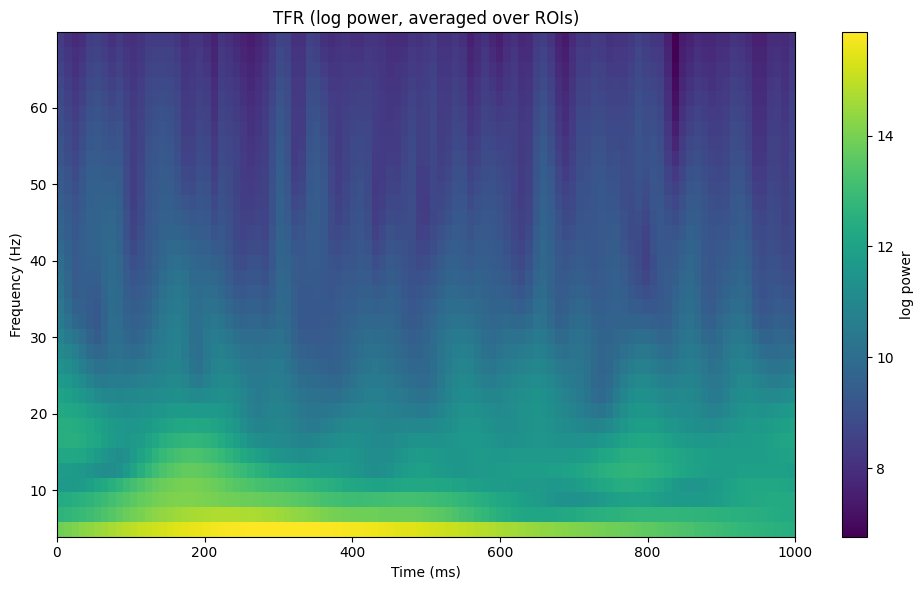

In [9]:
# Average over trials and ROIs
pow_avg = np.nanmean(np.nanmean(tensor, axis=0), axis=0)  # [Freq x Time]

plt.figure(figsize=(10, 6))
plt.imshow(np.log(pow_avg), aspect='auto', origin='lower',
           extent=[time_vec[0]*1000, time_vec[-1]*1000, freq_vec[0], freq_vec[-1]])
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')
plt.title('TFR (log power, averaged over ROIs)')
plt.colorbar(label='log power')
plt.axvline(0, color='white', linestyle='--')
plt.tight_layout()
plt.show()

In [42]:

pow = np.squeeze(tensor, axis=0)
pow.shape

(120, 34, 101)

In [43]:
Log_pow = np.log(pow)
Log1p_pow = np.log1p(pow)

In [44]:
np.all(Log_pow > 0)

np.False_

In [45]:
np.all(Log1p_pow > 0)

np.True_

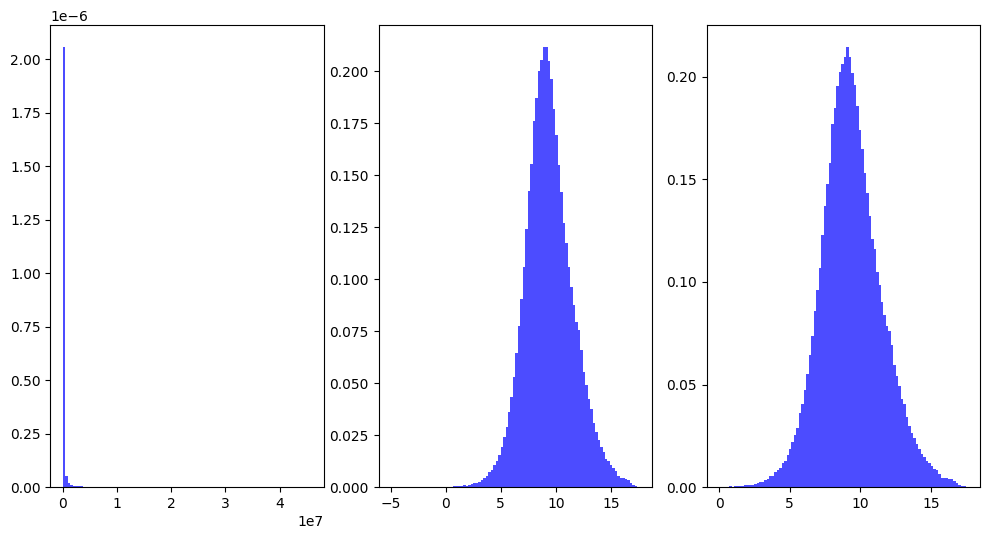

In [46]:
fig, ax = plt.subplots(1,3,figsize=(12,6))

ax[0].hist(pow.ravel(), bins=100, density=True, color='blue', alpha=0.7);
ax[1].hist(Log_pow.ravel(), bins=100, density=True, color='blue', alpha=0.7);
ax[2].hist(Log1p_pow.ravel(), bins=100, density=True, color='blue', alpha=0.7);

In [50]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
log1p_pow_torch = torch.as_tensor(Log1p_pow, device=device, dtype=torch.float32)
log1p_pow_torch.shape[0]

120

In [52]:
from tensorly.decomposition import non_negative_parafac_hals
import tensorly as tl
tl.set_backend('pytorch')

In [83]:
x = 5


cp_tensor_choice = non_negative_parafac_hals(
                log1p_pow_torch,
                rank=x,
                init="random",
                n_iter_max=2000,
                tol=1e-8,
                random_state=5
            )

In [ ]:
from tensorly.cp_tensor import cp_normalize

In [54]:
%cd ..

/content/drive/MyDrive


In [60]:
aal_nifti_path = 'aal2.nii'

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn import plotting
import torch  # Just for the type check

def to_numpy(x):
    """Safely converts PyTorch Tensors to NumPy arrays."""
    if hasattr(x, "detach"):
        return x.detach().cpu().numpy()
    elif hasattr(x, "numpy"):
        return x.numpy()
    else:
        return np.array(x)

def plot_factors_on_atlas(A, B, C, roi_labels, full_atlas_labels, aal_nifti_path):
    """
    Plot CP factors with NO trial mode.
    Expects:
      A: ROI/spatial weights  (n_rois, R)
      B: Frequency weights    (n_freqs, R)
      C: Time weights         (n_times, R)

    Spatial mode uses a signed-log transform so small nonzero ROI weights are visible
    on a glass brain WITHOUT thresholding.
    """
    # --- 1. CONVERT INPUTS TO NUMPY ---
    A = to_numpy(A)
    B = to_numpy(B)
    C = to_numpy(C)

    # --- 2. PRE-LOAD ATLAS ---
    aal_img = nib.load(aal_nifti_path)
    aal_data = aal_img.get_fdata()
    affine = aal_img.affine

    R = A.shape[1]

    for r in range(R):
        fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))
        fig.suptitle(f"Component {r+1}", fontsize=16, y=1.05)

        # --- MODE 1: ROIS (SPATIAL) ---
        roi_weights = A[:, r]
        roi_weights = np.nan_to_num(roi_weights, nan=0.0)

        brain_vol = np.zeros(aal_data.shape, dtype=float)
        for i, roi_name in enumerate(roi_labels):
            w = float(roi_weights[i])
            try:
                atlas_idx = full_atlas_labels.index(roi_name)
                atlas_id = atlas_idx + 1  # AAL labels are 1-indexed in the volume
                brain_vol[aal_data == atlas_id] = w
            except ValueError:
                # ROI name not found in atlas label list
                pass

        # ----- SIGNED LOG "NORMALISATION" (pre-transform for glass brain) -----
        nonzero = roi_weights[np.abs(roi_weights) > 0]
        if nonzero.size == 0:
            eps = 1e-12
        else:
            # scale where the log starts being noticeable; tune percentile if desired
            eps = np.percentile(np.abs(nonzero), 5)
            eps = max(eps, 1e-12)

        brain_vol_log = np.sign(brain_vol) * np.log10(1.0 + np.abs(brain_vol) / eps)
        weight_nii = nib.Nifti1Image(brain_vol_log, affine)

        # Robust symmetric scaling for display
        nzv = brain_vol_log[brain_vol_log != 0]
        if nzv.size == 0:
            vmax = 1.0
        else:
            vmax = np.percentile(np.abs(nzv), 99)
            vmax = max(vmax, 1e-6)

        plotting.plot_glass_brain(
            weight_nii,
            axes=axes[0],
            display_mode="ortho",
            threshold=0.0,     # remove thresholding
            colorbar=True,
            plot_abs=False,    # keep sign
            vmax=vmax,
            cmap="cold_hot"
        )
        axes[0].set_title("Spatial (signed log, no threshold)")

        # --- MODE 2: FREQUENCY ---
        freq_axis = np.linspace(0, 70, len(B[:, r]))
        axes[1].plot(freq_axis, B[:, r], color="tab:green", alpha=0.8, linewidth=2)
        axes[1].set_title("Frequency")
        axes[1].set_xlabel("Hz")
        axes[1].grid(True, alpha=0.3)

        # --- MODE 3: TIME ---
        time_axis = np.linspace(0, 1500, len(C[:, r]))
        axes[2].plot(time_axis, C[:, r], color="k", linewidth=1.5)
        axes[2].set_title("Time")
        axes[2].set_xlabel("ms")
        axes[2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()


In [84]:
weights,  factors = cp_tensor_choice
A,B,C = factors

In [87]:
%cd ..

/content/drive/MyDrive/OPM-MEG


In [98]:
from tensorly.cp_tensor import cp_normalize

In [99]:
cp_tensor_norm = cp_normalize(cp_tensor_choice)

In [112]:
weights,  factors = cp_tensor_norm
A,B,C = factors

/tmp/ipython-input-3781717090.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


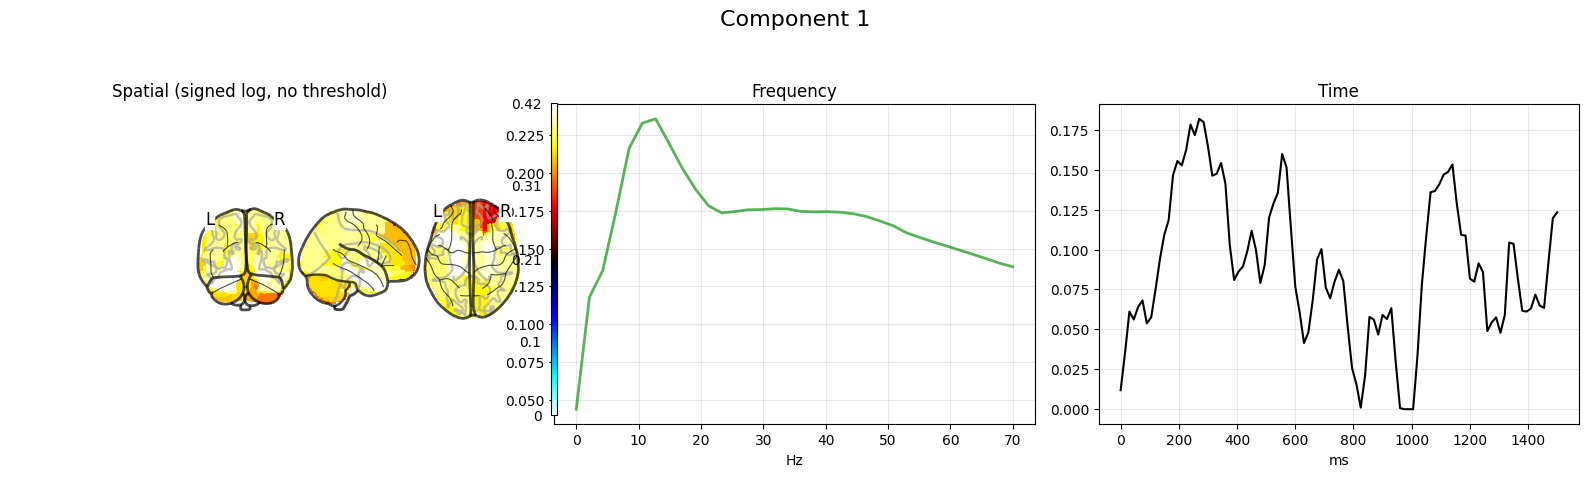

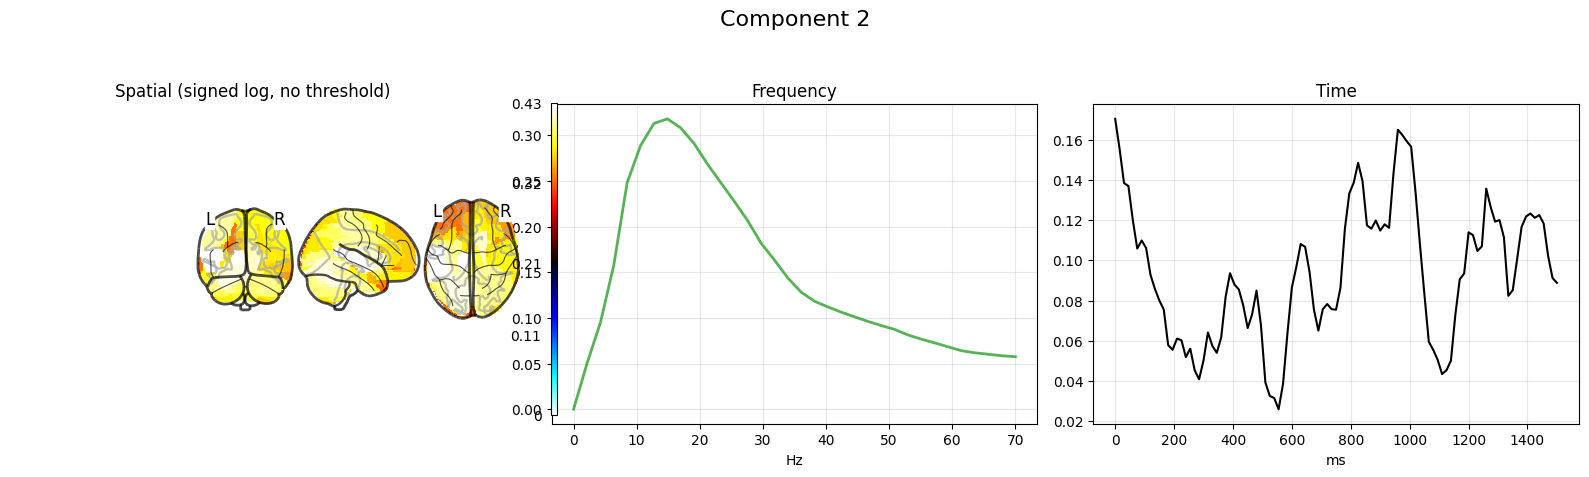

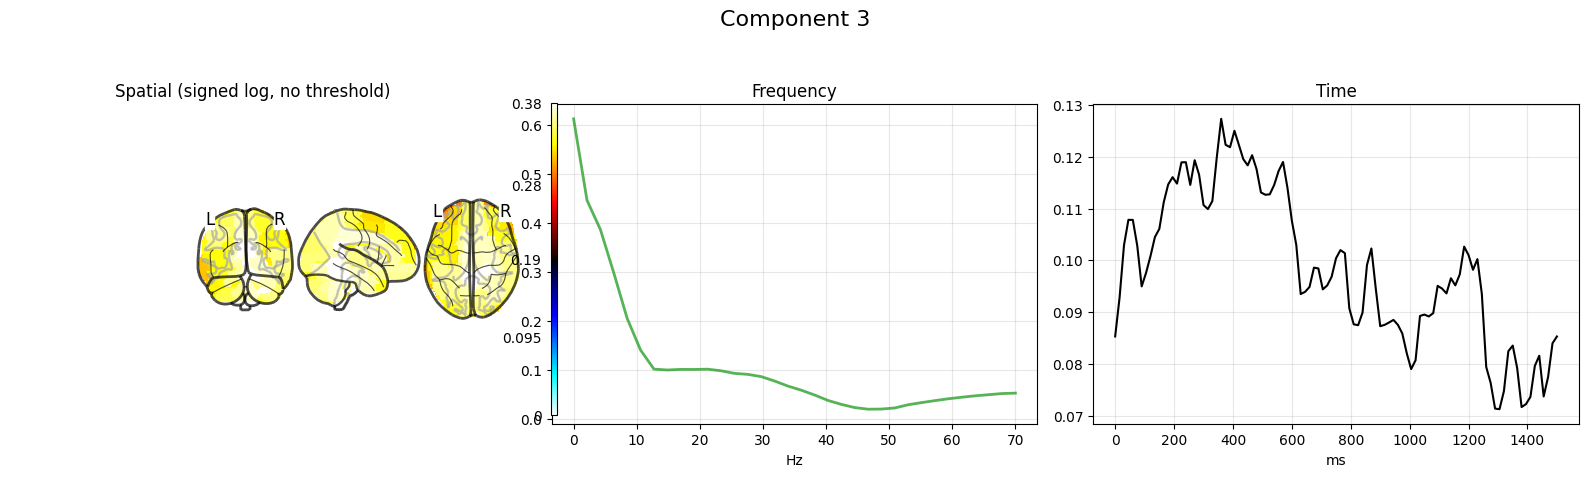

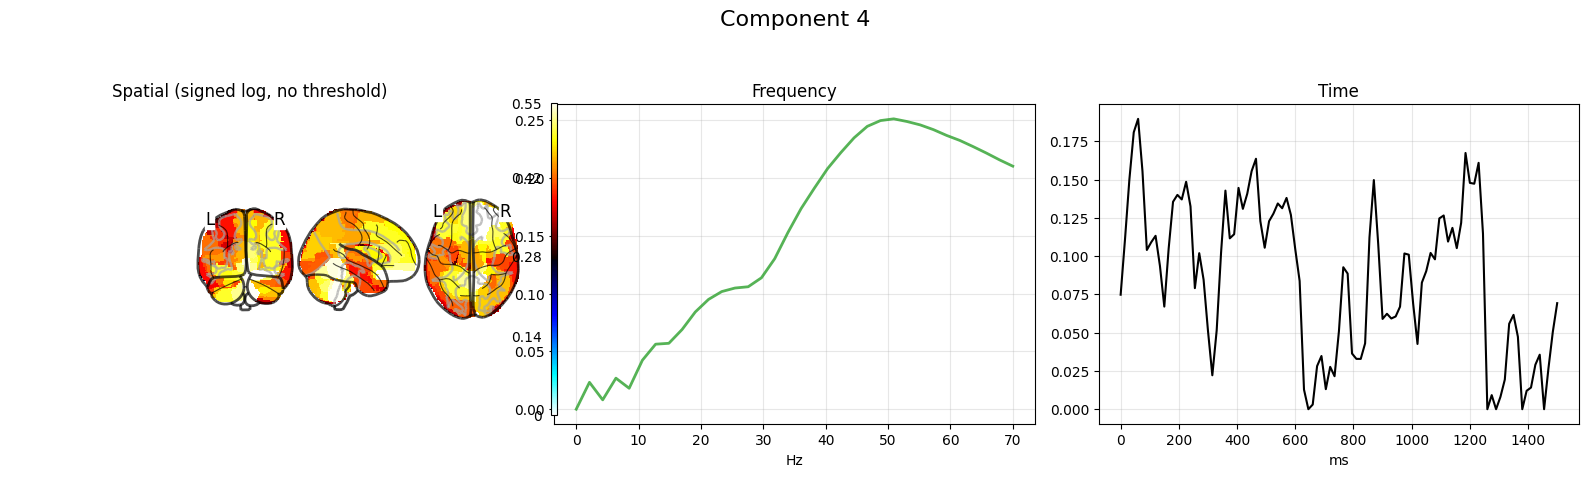

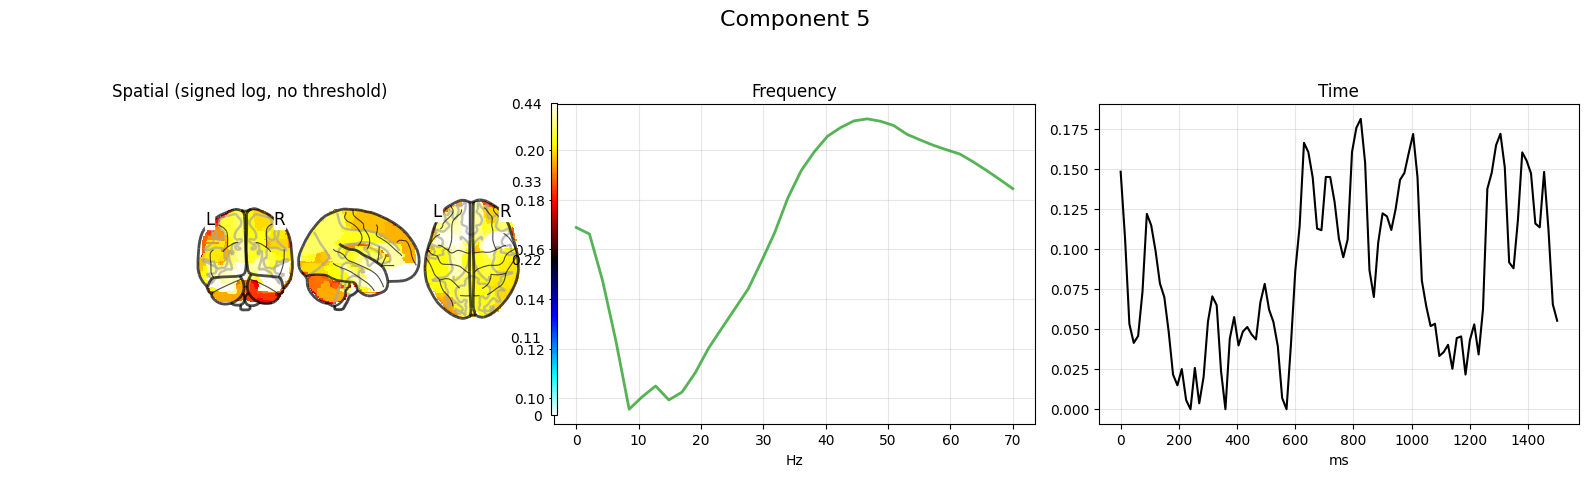

In [113]:
plot_factors_on_atlas(A,B,C,roi_labels, roi_labels, aal_nifti_path)

In [104]:
pp = A[:,1].to('cpu').numpy()

In [105]:
pp.shape

(120,)

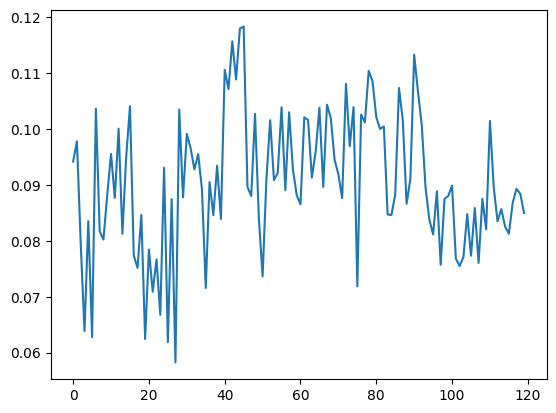

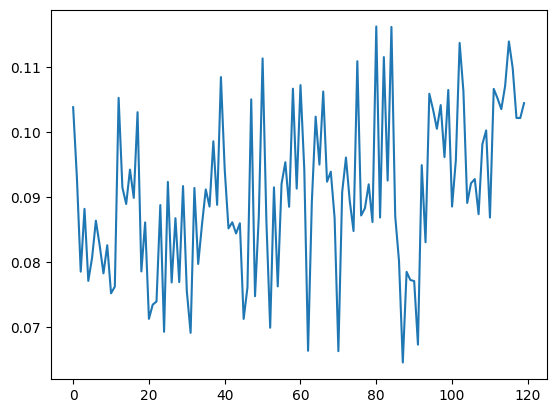

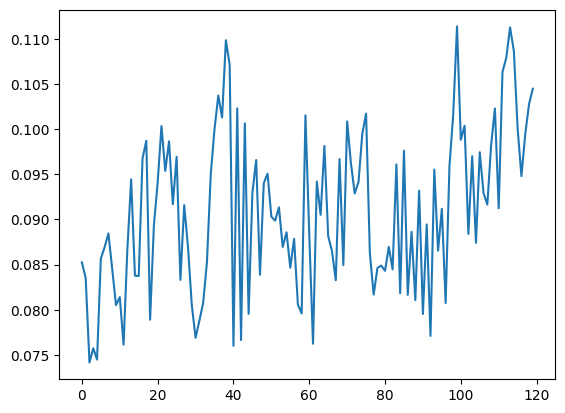

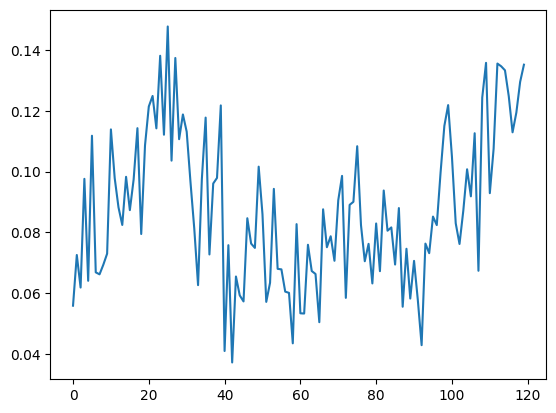

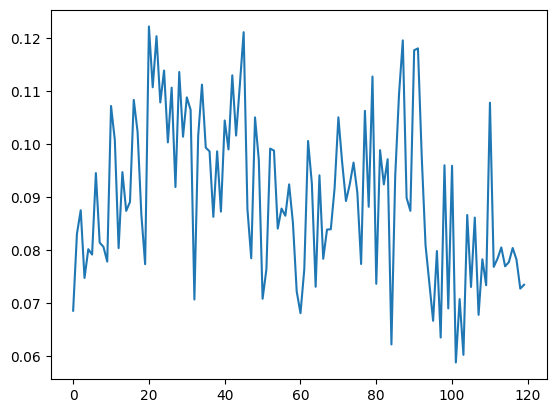

In [107]:
for r in range(A.shape[1]):
  plt.figure()
  plt.plot(A[:,r].to('cpu').numpy())

In [75]:
%cd Tensor-Decompositions-OPM-MEG/

/content/drive/MyDrive/OPM-MEG/Tensor-Decompositions-OPM-MEG


In [77]:
from src.tools.rankselection import rank_stability

In [79]:
from tqdm import tqdm

In [81]:
ranks = np.arange(1,5,1)

stabilities = []
stds = []

for i in tqdm(ranks):

    stability,std = rank_stability(log1p_pow_torch,i,n_repeats=5)


    stabilities.append(stability)
    stds.append(std)

 50%|█████     | 2/4 [00:38<00:38, 19.15s/it]


KeyboardInterrupt: 

In [ ]:
plt.plot(ranks,stabilities)